I needed to plan the monthly budget levels for a clients two biggest brands. Both brands followed similar seasonal patterns, so I used seasonal decomposition to provide a baseline for my weekly spending estimates.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import psycopg2

from creds import pg_password, brand_1, brand_2


# hide sql alchemy warning in pandas
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
conn = psycopg2.connect(dbname="test_reporting", user = "postgres", host="localhost", password=pg_password, port = "5432")
sql = f"""
select date
	,sum(coalesce(sessions,0)) filter (where account = '{brand_1}' and "channelGrouping" = 'Organic Search') as brand1_sessions
	,sum(coalesce(sessions,0)) filter (where account = '{brand_2}' and "channelGrouping" = 'Organic Search') as brand2_sessions
from website_tracker
group by date
having date >= '2014-01-01' and date <= '2022-12-31'
order by date asc
"""
df = pd.read_sql(sql, conn)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [3]:
def decomp(df=None, metric=None, plot=False):
    decompose_result_mult = seasonal_decompose(df[metric], model = "additive", period=365)
    trend = decompose_result_mult.trend
    seasonal = decompose_result_mult.seasonal
    residual = decompose_result_mult.resid
    if plot == True:
        decompose_result_mult.plot()
    return seasonal, trend, residual

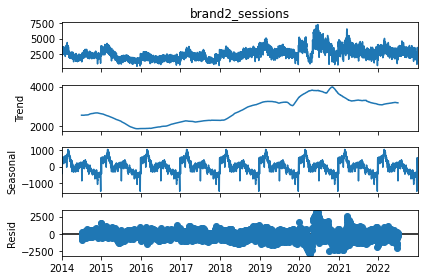

In [5]:
a_seasonal, a_trend, a_residual = decomp(df,'brand1_sessions')
b_seasonal, b_trend, b_residual = decomp(df,'brand2_sessions', True)
a_seasonal_year = a_seasonal[(a_seasonal.index >= '2022-01-01') & (a_seasonal.index <= '2022-12-31')]
b_seasonal_year = b_seasonal[(b_seasonal.index >= '2022-01-01') & (b_seasonal.index <= '2022-12-31')]

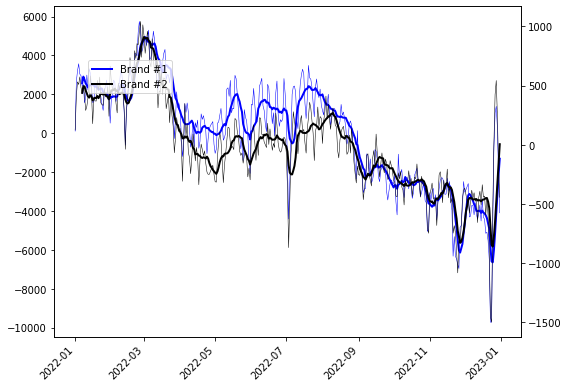

In [6]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(a_seasonal_year, linewidth = 0.5, color = "blue")
ax.plot(a_seasonal_year.rolling(7).mean(), linewidth = 2, color = "blue", label = "Brand #1")
ax2.plot(b_seasonal_year, linewidth = 0.5, color = "black")
ax2.plot(b_seasonal_year.rolling(7).mean(), linewidth = 2, color = "black", label = "Brand #2")
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.35, 0.5, 0.5))
fig.autofmt_xdate(rotation=45)
fig.set_size_inches(8,5.5)
fig.tight_layout()
plt.show()